# Aprendizaje Automatico - TP 1

In [2]:
%matplotlib inline

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time, strftime

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [5]:
import simple_features as sf
import email_text_retrieval as etr

#### Funciones Auxiliares

In [6]:
def load_data(max_rows_per_class=None, test_size=0.20):
    ham_txt = json.load(open('dataset/ham_dev.json'))
    spam_txt = json.load(open('dataset/spam_dev.json'))
    
    if max_rows_per_class is not None:
        ham_txt = ham_txt[1:max_rows_per_class]
        spam_txt = spam_txt[1:max_rows_per_class]
    
    df = pd.DataFrame(ham_txt + spam_txt, columns=['text'])
    df['label'] = ['ham' for _ in range(len(ham_txt))] + ['spam' for _ in range(len(spam_txt))]
    return train_test_split(df, test_size=test_size)

In [7]:
def cross_validate(clf, X_train, y_train, cv_folds=5, n_jobs=4):
    clf_descr = str(clf).split('(')[0]
    print "Running %d-Fold Cross Validation for %s" % (cv_folds, clf_descr)
    
    t0 = time()
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_folds, n_jobs=n_jobs)
    cv_time = time() - t0
    
    print "Done in %fs" % cv_time
    print "CV Score: mean %f std %f" % (np.mean(cv_scores), np.std(cv_scores))

In [8]:
def extract_features(feature_extractor_tuple, dataset_tuple):
    feature_extractor, feature_extractor_descr = feature_extractor_tuple
    data_train, data_test = dataset_tuple
    
    print "Extracting features from the training data using a %s" % feature_extractor_descr
    t0 = time()
    X_train = feature_extractor.fit_transform(data_train.text)
    duration = time() - t0    
    print "Done in %fs" % duration
    
    print "Extracting features from the test data using the same %s" % feature_extractor_descr
    t0 = time()
    X_test = feature_extractor.transform(data_test.text)
    duration = time() - t0    
    print "Done in %fs" % duration
   
    print ""
    
    print "Training Set: %d samples %d features" % X_train.shape
    print "Test     Set: %d samples %d features" % X_test.shape
    
    print ""
    
    return X_train, X_test, feature_extractor

In [9]:
def fit(clf_tuple, X_train, y_train):
    clf, clf_descr = clf_tuple
    
    print "Fitting a %s Classifier" % clf_descr
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0    
    print "Done in %fs" % train_time
    print ""    
    
    return clf, clf_descr

In [10]:
def benchmark(clf_tuple, X_train, y_train, X_test, y_test):
    clf, clf_descr = clf_tuple
    
    print "Running Test Score on %s" % clf_descr
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    
    test_score = metrics.accuracy_score(y_test, pred)
    print "Done in %fs" % test_time    
    print "Test Score:   %f" % test_score
    
    classes = np.unique(y_test)

    print "Classification report:"
    print metrics.classification_report(y_test, pred, labels=classes)

    plt.matshow(metrics.confusion_matrix(y_test, pred), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('Confusion matrix',)
    plt.colorbar()
    plt.ylabel('Expected label')
    plt.xlabel('Predicted label')

In [18]:
def train_benchmark_and_save(feature_extractor_tuple, clf_tuple, dataset_tuple):
    X_train, X_test, feature_extractor = extract_features(feature_extractor_tuple, dataset_tuple)
    data_train, data_test = dataset_tuple
    clf_tuple = fit(clf_tuple, X_train, data_train.label)    
    benchmark(clf_tuple, X_train, data_train.label, X_test, data_test.label)

    directory = 'results\%s-%s\%s' % (feature_extractor_tuple[1], clf_tuple[1], strftime("%Y%m%d-%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    joblib.dump(feature_extractor, '%s\\extractor.pkl' % directory, compress=True)
    joblib.dump(clf_tuple[0], '%s\\classifier.pkl' % directory, compress=True)
    

## Features

Aca definimos distintos tipos de features para hacer las pruebas

In [12]:
def simple_features(data_train, data_test):
    # Extraigo dos atributos simples: 
    # 1) Longitud del mail.
    # 2) Cantidad de espacios en el mail.
    extractors = [ ('length', len), ('count_spaces', sf.count_spaces) ]
    feature_extractor = sf.SimpleFeaturesExtractor(extractors)
    feature_names = [ e[0] for e in extractors ]

    return feature_extractor, "SimpleFeaturesExtractor"

In [13]:
def vectorizer_features(data_train, data_test, vectorizer_type, use_custom_tokenizer=False, **kwargs):
    tokenizer = etr.LemmaTokenizer() if use_custom_tokenizer else None    
    if vectorizer_type == "count":
        vectorizer = CountVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "BagOfWords"        
    elif vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "TfIdf"
    elif vectorizer_type == "hashing":
        vectorizer = HashingVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "HashingBagOfWords"
    else:
        raise ValueError('Invalid vectorizer_type. Expected \'count\', \'tfidf\' or \'hashing\'')
    
    return vectorizer, "%sSparseVectorizer" % vectorizer_descr

## Experimentacion

### Carga de datos

Cargamos y spliteamos el dataset

In [14]:
data_train, data_test = load_data(test_size=0.20)
print "Training Set: %d samples (%0.3fMB)" % (len(data_train), sum(len(m.encode('utf-8')) for m in data_train.text) / 1e6)
print "Test Set:     %d samples (%0.3fMB)" % (len(data_test), sum(len(m.encode('utf-8')) for m in data_test.text) / 1e6)

Training Set: 72000 samples (522.824MB)
Test Set:     18000 samples (142.965MB)


### Pruebas de Features

Aca probamos distintos tipos de features. Mediante la funcion 'train_benchmark_and_save' entrenamos, benchmarkeamos y grabamos en disco los resultados y modelos de cada combinacion que decidimos probar

#### Features del Baseline Example

Extracting features from the training data using a SimpleFeaturesExtractor
Done in 0.520000s
Extracting features from the test data using the same SimpleFeaturesExtractor
Done in 0.125000s

Training Set: 72000 samples 2 features
Test     Set: 18000 samples 2 features

Fitting a DecisionTree Classifier
Done in 0.167000s

Running Test Score on DecisionTree
Done in 0.004000s
Test Score:   0.695000
Classification report:
             precision    recall  f1-score   support

        ham       0.69      0.71      0.70      8944
       spam       0.70      0.68      0.69      9056

avg / total       0.70      0.69      0.69     18000



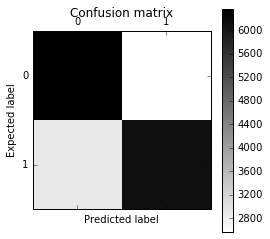

In [15]:
train_benchmark_and_save(
    simple_features(data_train, data_test), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

##### Distintos tipos de Features nuestros

Extracting features from the training data using a BagOfWordsSparseVectorizer
Done in 71.906000s
Extracting features from the test data using the same BagOfWordsSparseVectorizer
Done in 10.161000s

Training Set: 72000 samples 5963342 features
Test     Set: 18000 samples 5963342 features

Fitting a DecisionTree Classifier
Done in 150.159000s

Running Test Score on DecisionTree
Done in 0.062000s
Test Score:   0.994556
Classification report:
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99      8944
       spam       1.00      0.99      0.99      9056

avg / total       0.99      0.99      0.99     18000



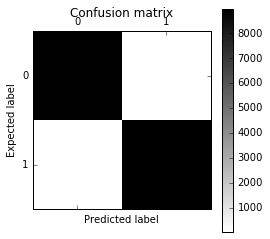

In [19]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'count', use_custom_tokenizer=False), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a TfIdfSparseVectorizer
Done in 74.838000s
Extracting features from the test data using the same TfIdfSparseVectorizer
Done in 11.993000s

Training Set: 72000 samples 2408 features
Test     Set: 18000 samples 2408 features

Fitting a DecisionTree Classifier
Done in 10.664000s

Running Test Score on DecisionTree
Done in 0.016000s
Test Score:   0.992056
Classification report:
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      8980
       spam       0.99      0.99      0.99      9020

avg / total       0.99      0.99      0.99     18000



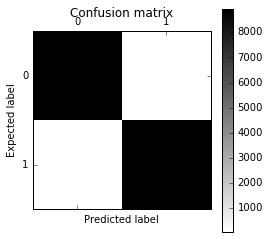

In [16]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'tfidf', use_custom_tokenizer=False, sublinear_tf=True, min_df=0.01, max_df=0.7), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a HashingBagOfWordsSparseVectorizer
Done in 45.258000s
Extracting features from the test data using the same HashingBagOfWordsSparseVectorizer
Done in 11.658000s

Training Set: 72000 samples 262144 features
Test     Set: 18000 samples 262144 features

Fitting a DecisionTree Classifier
Done in 49.250000s

Running Test Score on DecisionTree
Done in 0.046000s
Test Score:   0.992056
Classification report:
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      8965
       spam       0.99      0.99      0.99      9035

avg / total       0.99      0.99      0.99     18000



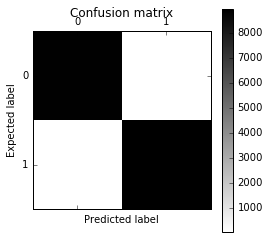

In [17]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'hashing', use_custom_tokenizer=False, non_negative=True, n_features=2 ** 18), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

In [ ]:
### Este no lo corro porque tarda años
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'count', use_custom_tokenizer=True), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a TfIdfSparseVectorizer
Done in 26506.078000s
Extracting features from the test data using the same TfIdfSparseVectorizer
Done in 165.881000s

Training Set: 72000 samples 2179 features
Test     Set: 18000 samples 2179 features

Fitting a DecisionTree Classifier
Done in 12.026000s

Running Test Score on DecisionTree
Done in 0.015000s
Test Score:   0.990278
Classification report:
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      8980
       spam       0.99      0.99      0.99      9020

avg / total       0.99      0.99      0.99     18000



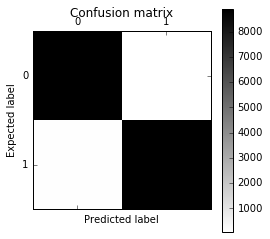

In [19]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'tfidf', use_custom_tokenizer=True, sublinear_tf=True, min_df=0.01, max_df=0.7), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a HashingBagOfWordsSparseVectorizer
Done in 26503.592000s
Extracting features from the test data using the same HashingBagOfWordsSparseVectorizer
Done in 164.190000s

Training Set: 72000 samples 262144 features
Test     Set: 18000 samples 262144 features

Fitting a DecisionTree Classifier
Done in 36.783000s

Running Test Score on DecisionTree
Done in 0.032000s
Test Score:   0.993056
Classification report:
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      8965
       spam       0.99      0.99      0.99      9035

avg / total       0.99      0.99      0.99     18000



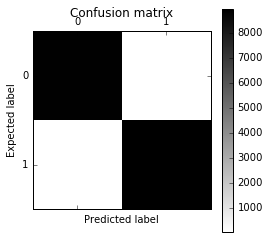

In [20]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'hashing', use_custom_tokenizer=True, non_negative=True, n_features=2 ** 18), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))